In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline  
import matplotlib as mpl

from sklearn.model_selection import train_test_split
from sklearn.externals import joblib 
from sklearn.metrics import classification_report, confusion_matrix
# ComplementNB is Naive Bayes classifier for unbalance data
from sklearn.naive_bayes import ComplementNB
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
data = pd.read_csv('classification-datasets.csv')

In [3]:
data.describe()

,height_cm,weight_kg
count,18278.000000,18278.000000
mean,181.362184,75.276343
std,6.756961,7.047744
min,156.000000,50.000000
25%,177.000000,70.000000
50%,181.000000,75.000000
75%,186.000000,80.000000
max,205.000000,110.000000


In [4]:
data

,height_cm,weight_kg,body_type
0,170,72,Normal
1,187,83,Normal
2,175,68,Lean
3,188,87,Normal
4,175,74,Normal
...,...,...,...
18273,186,79,Normal
18274,177,66,Normal
18275,186,75,Lean
18276,185,74,Lean


In [5]:
data['normalized_H'] = (data['height_cm'] - data['height_cm'].min()) / (data['height_cm'].max() - data['height_cm'].min())
data['normalized_W'] = (data['weight_kg'] - data['weight_kg'].min()) / (data['weight_kg'].max() - data['weight_kg'].min())

In [6]:
data

,height_cm,weight_kg,body_type,normalized_H,normalized_W
0,170,72,Normal,0.285714,0.366667
1,187,83,Normal,0.632653,0.550000
2,175,68,Lean,0.387755,0.300000
3,188,87,Normal,0.653061,0.616667
4,175,74,Normal,0.387755,0.400000
...,...,...,...,...,...
18273,186,79,Normal,0.612245,0.483333
18274,177,66,Normal,0.428571,0.266667
18275,186,75,Lean,0.612245,0.416667
18276,185,74,Lean,0.591837,0.400000


In [7]:
data.groupby('body_type').agg('count')

,height_cm,weight_kg,normalized_H,normalized_W
body_type,,,,
Lean,6506,6506,6506,6506
Normal,10753,10753,10753,10753
Stocky,1019,1019,1019,1019


### Check for missing value in the data

In [8]:
missing_values = data.isnull().sum()
missing_values

height_cm       0
weight_kg       0
body_type       0
normalized_H    0
normalized_W    0
dtype: int64

#### Function to plot the outliers data

In [9]:
def boxPlot(data1, data2):
    mpl.rcParams['figure.dpi'] = 100
    plt.figure(figsize=(60, 60))
    f, axes = plt.subplots(1, 2)
    sns.boxplot(y=data1, ax=axes[0])
    sns.boxplot(y=data2, ax=axes[1])
    plt.subplots_adjust(wspace=1)

<Figure size 6000x6000 with 0 Axes>

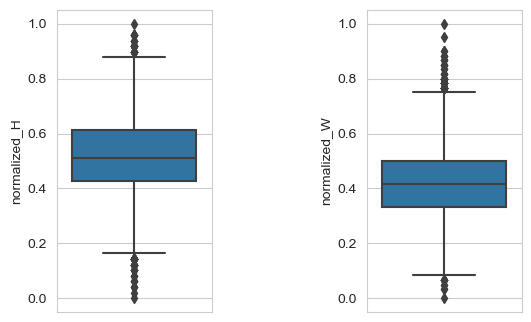

In [10]:
boxPlot(data["normalized_H"], data["normalized_W"])

#### Formula to find out upper limit and lower limit from Outliers

In [11]:
def setbound(datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    print(Q1, Q3)
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range,upper_range

#### Get the outliers data

In [12]:
def getOutlierData(data, mainData):
    lowerbound,upperbound = setbound(data)
    return mainData[(data < lowerbound) | (data > upperbound)]

#### Drop the outliers data

In [13]:
def outliering(data1, data2, mainData):
    # Loop until outliers is clean
    while True:
        lowerbound,upperbound = setbound(data1)
        res1 = getOutlierData(data1, mainData)

        lowerbound,upperbound = setbound(data2)
        res2 = getOutlierData(data2, mainData)
        
        res = pd.concat([res1,res2]).drop_duplicates()
        res = res.index

        print('Total Outliers = ',len(res))
        print('=== The Outliers ===')
        print(res)    
        mainData.drop(res, inplace=True)

        if(len(res)==0):
            break
    print("BLOXPOT AFTER OUTLIERING")
    boxPlot(mainData['normalized_H'], mainData['normalized_W'])
    return mainData

0.42857142857142855 0.6122448979591837
0.42857142857142855 0.6122448979591837
0.3333333333333333 0.5
0.3333333333333333 0.5
Total Outliers =  127
=== The Outliers ===
Int64Index([   54,   355,   393,   628,   776,   909,  1352,  1496,  1834,
             1923,
            ...
            11945, 12666, 13070, 13254, 13576, 15064, 16695, 17158, 17612,
            17772],
           dtype='int64', length=127)
0.42857142857142855 0.6122448979591837
0.42857142857142855 0.6122448979591837
0.3333333333333333 0.5
0.3333333333333333 0.5
Total Outliers =  24
=== The Outliers ===
Int64Index([ 4243,  5060,  6715,  7554,  7648, 10661, 11484, 11759, 12549,
            15805, 16268, 16492, 16664, 17587, 18103,   165,  5843,  8587,
            10665, 11965, 13201, 17022, 17078, 17817],
           dtype='int64')
0.42857142857142855 0.6122448979591837
0.42857142857142855 0.6122448979591837
0.3333333333333333 0.5
0.3333333333333333 0.5
Total Outliers =  3
=== The Outliers ===
Int64Index([12880, 14546, 16

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 6000x6000 with 0 Axes>

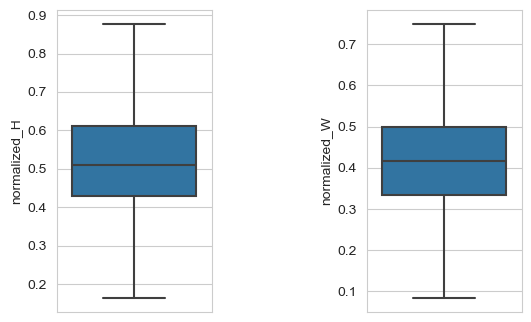

In [14]:
newData = outliering(data["normalized_H"], data["normalized_W"], data)

In [15]:
newData

,height_cm,weight_kg,body_type,normalized_H,normalized_W
0,170,72,Normal,0.285714,0.366667
1,187,83,Normal,0.632653,0.550000
2,175,68,Lean,0.387755,0.300000
3,188,87,Normal,0.653061,0.616667
4,175,74,Normal,0.387755,0.400000
...,...,...,...,...,...
18273,186,79,Normal,0.612245,0.483333
18274,177,66,Normal,0.428571,0.266667
18275,186,75,Lean,0.612245,0.416667
18276,185,74,Lean,0.591837,0.400000


#### Get Independen Data

In [16]:
data_train = []
for item in newData.values:
    data_train.append([item[3], item[4]])
data_train

[[0.2857142857142857, 0.36666666666666664],
 [0.6326530612244898, 0.55],
 [0.3877551020408163, 0.3],
 [0.6530612244897959, 0.6166666666666667],
 [0.3877551020408163, 0.4],
 [0.5102040816326531, 0.3333333333333333],
 [0.6326530612244898, 0.5833333333333334],
 [0.7551020408163265, 0.7],
 [0.32653061224489793, 0.26666666666666666],
 [0.3877551020408163, 0.35],
 [0.4489795918367347, 0.38333333333333336],
 [0.6326530612244898, 0.65],
 [0.6530612244897959, 0.65],
 [0.7142857142857143, 0.6833333333333333],
 [0.7346938775510204, 0.5333333333333333],
 [0.24489795918367346, 0.36666666666666664],
 [0.6326530612244898, 0.5833333333333334],
 [0.3469387755102041, 0.3333333333333333],
 [0.5714285714285714, 0.5333333333333333],
 [0.5306122448979592, 0.6],
 [0.5714285714285714, 0.5],
 [0.673469387755102, 0.43333333333333335],
 [0.40816326530612246, 0.38333333333333336],
 [0.42857142857142855, 0.4166666666666667],
 [0.7142857142857143, 0.5666666666666667],
 [0.6530612244897959, 0.6],
 [0.285714285714285

In [17]:
data_train = np.array(data_train)

#### Get Dependen Data

In [18]:
label = np.array(newData['body_type'])

### Split the Dataset

In [19]:
#split dataset 80% for train and 20% test it randomize every to keep the sequential every 700 random data is same as before
x_train, x_test, y_train, y_test = train_test_split(data_train, label, test_size = 0.2, random_state = 700)

## Naive Bayes

#### Make Naive Bayes Classifier

In [20]:
classifierNB = ComplementNB()

#### Predict datatest using the NB Model

In [21]:
classifierNB.fit(x_train, y_train)

ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)

In [22]:
hasilNB = classifierNB.predict(x_test)

#### Evaluate Model

In [23]:
print(classification_report(y_test, hasilNB))

              precision    recall  f1-score   support

        Lean       0.52      0.64      0.57      1311
      Normal       0.67      0.64      0.66      2108
      Stocky       0.00      0.00      0.00       206

    accuracy                           0.60      3625
   macro avg       0.40      0.43      0.41      3625
weighted avg       0.58      0.60      0.59      3625



C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
classes = ['Normal', 'Lean', 'Stocky']

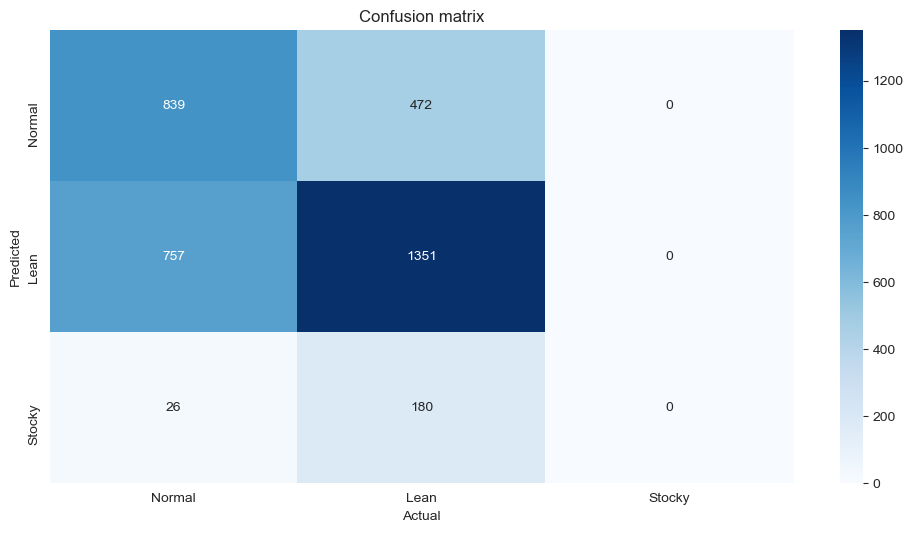

In [25]:
conf_matrix = confusion_matrix(y_test, hasilNB)
plt.figure(figsize=(12,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=classes, 
            yticklabels=classes,
            cmap="Blues",
            fmt='d')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

#### Saving Naive Bayes Model

In [26]:
joblib.dump(classifierNB, "classification-NB.h5")

['classification-NB.h5']

## SVM

#### Make SVM Classifier

In [27]:
classifierSVM = svm.SVC(decision_function_shape='ovo')
classifierSVM.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

#### Predict datatest using the SVM Model

In [28]:
hasilSVM = classifierSVM.predict(x_test)

#### Evaluate Model

In [29]:
print(classification_report(y_test, hasilSVM))

              precision    recall  f1-score   support

        Lean       0.62      0.30      0.41      1311
      Normal       0.63      0.89      0.74      2108
      Stocky       0.00      0.00      0.00       206

    accuracy                           0.63      3625
   macro avg       0.42      0.40      0.38      3625
weighted avg       0.59      0.63      0.58      3625



C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


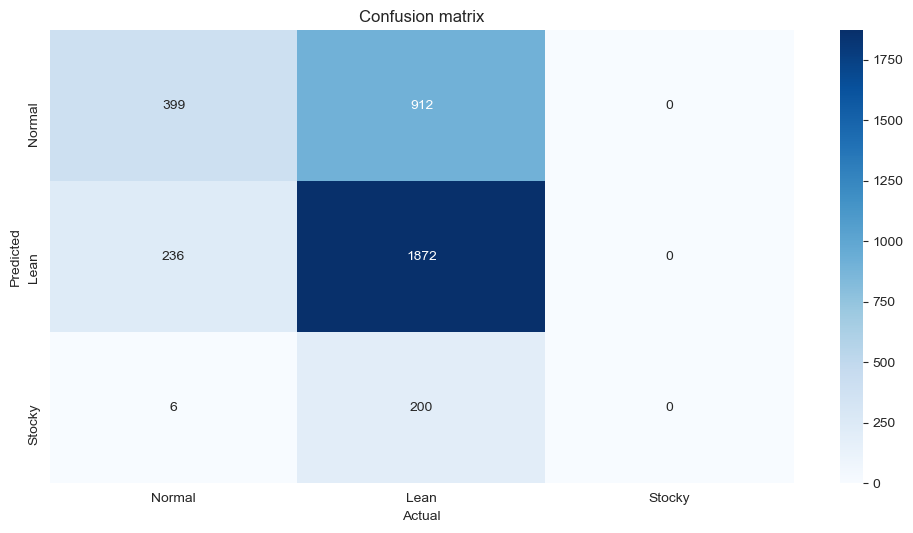

In [30]:
conf_matrix = confusion_matrix(y_test, hasilSVM)
plt.figure(figsize=(12,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=classes, 
            yticklabels=classes,
            cmap="Blues",
            fmt='d')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

#### Saving SVM Model

In [31]:
joblib.dump(classifierSVM, "classification-SVM.h5")

['classification-SVM.h5']

## SGD

#### Make SVM Classifier

In [32]:
classifierSGD = SGDClassifier()

In [33]:
classifierSGD.fit(x_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

#### Predict datatest using the SGD Model

In [34]:
hasilSGD = classifierSGD.predict(x_test)

#### Evaluate Model

In [35]:
print(classification_report(y_test, hasilSGD))

              precision    recall  f1-score   support

        Lean       0.65      0.19      0.30      1311
      Normal       0.61      0.94      0.74      2108
      Stocky       0.00      0.00      0.00       206

    accuracy                           0.61      3625
   macro avg       0.42      0.38      0.34      3625
weighted avg       0.59      0.61      0.54      3625



C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


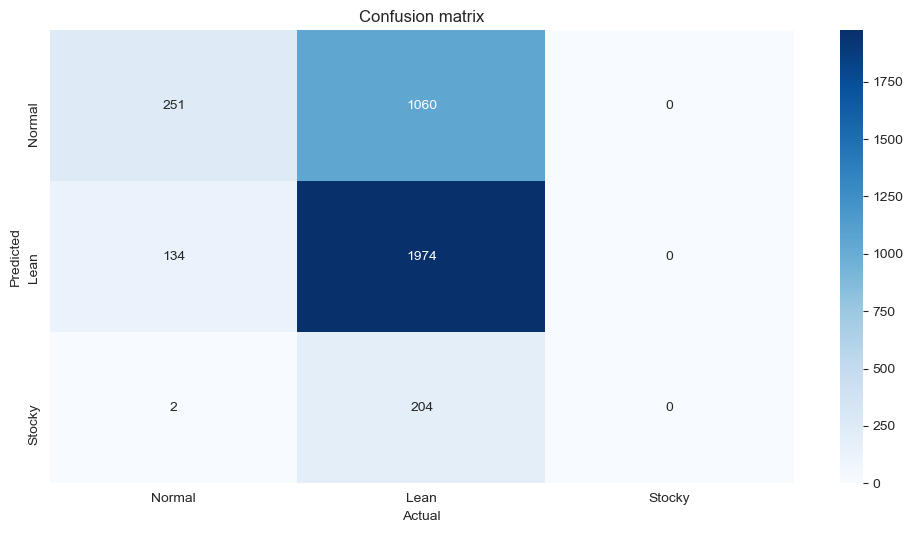

In [36]:
conf_matrix = confusion_matrix(y_test, hasilSGD)
plt.figure(figsize=(12,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=classes, 
            yticklabels=classes,
            cmap="Blues",
            fmt='d')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

#### Saving SGD Model

In [37]:
joblib.dump(classifierSGD, "classification-SGD.h5")

['classification-SGD.h5']

## Neural Network ( Multi Layer Percepton)

#### Make SVM Classifier

In [38]:
# Make neural network layer with 10 hidden layer
classifierNN = MLPClassifier(hidden_layer_sizes=(10,))

In [39]:
classifierNN.fit(x_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

#### Predict datatest using the Neural Network Model

In [40]:
hasilNN = classifierNN.predict(x_test)

#### Evaluate Model

In [41]:
print(classification_report(y_test, hasilNN))

              precision    recall  f1-score   support

        Lean       0.60      0.41      0.49      1311
      Normal       0.64      0.84      0.73      2108
      Stocky       0.67      0.01      0.02       206

    accuracy                           0.63      3625
   macro avg       0.64      0.42      0.41      3625
weighted avg       0.63      0.63      0.60      3625



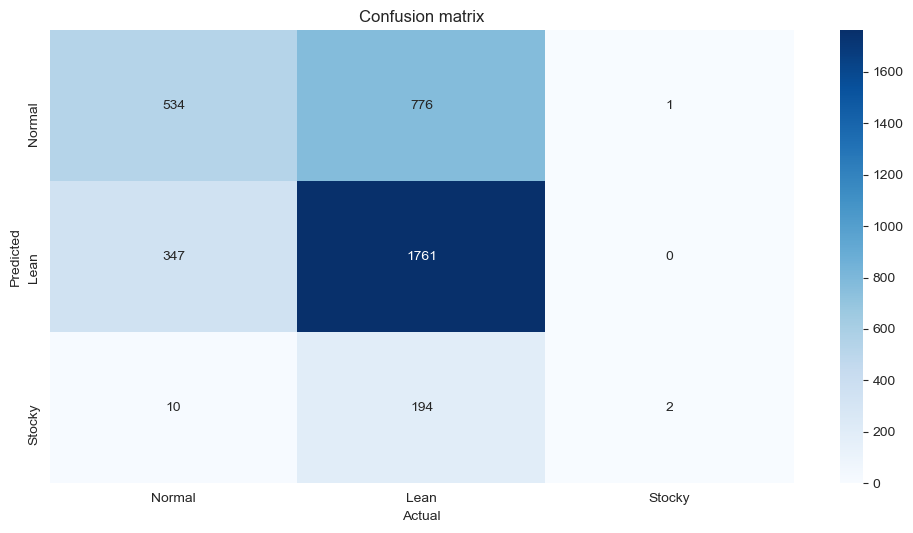

In [42]:
conf_matrix = confusion_matrix(y_test, hasilNN)
plt.figure(figsize=(12,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=classes, 
            yticklabels=classes,
            cmap="Blues",
            fmt='d')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

#### Saving Neural Network Model

In [43]:
joblib.dump(classifierNN, "classification-NN.h5")

['classification-NN.h5']

## Conclusion

From all experiment that we did we got conclusion that using :
1. SVM, and Neural Network model give us accuracy 63%
2. Naive Bayes model give 60%
3. SGD model give 61 %

So we can conclude that SVM and Neural Network give the best model for this experiment

<p>Copyright &copy; 2020 <a href=https://www.linkedin.com/in/pratamays/>Pratama Yoga Santosa</a> </p>